In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, '../preprocess')

import preprocess as pre
import embedding as em
import plotting
import matplotlib.pyplot as plt

Size of Train Set is: 5552
Size of Validation Set is: 1388
Size of Test Set is: 1735


In [3]:
train = pre.train
valid = pre.valid
test = pre.test

train.head()

,type,posts,Average Words Per Comment,Variance of Word Counts,Cleaned Posts,IE,NS,TF,JP,Average Words Per Comment Scaled,Variance of Word Counts Scaled
570,ISTP,'I journal. Only in times of severe depression...,33.54,64.4096,'i journal. only in times of severe depression...,I,S,T,P,1.441291,-1.493830
5719,ISFP,'So I've been noticing like the past week or s...,11.38,153.2704,'so i've been noticing like the past week or s...,I,S,F,P,-2.072472,0.318110
5649,ISFP,'4w5 and i'll still probably never completely ...,29.74,109.2816,' <NUM> w <NUM> and i'll still probably never ...,I,S,F,P,0.838750,-0.578855
860,INFP,'Even the loner gets lonely. I feel like it's ...,25.34,233.2576,'even the loner gets lonely. i feel like it's ...,I,N,F,P,0.141072,1.949110
4908,INTJ,'Count me in. Notification of new PM but there...,25.52,170.0900,'count me in. notification of new pm but there...,I,N,T,J,0.169613,0.661074


In [4]:
avg_word_col = train['Average Words Per Comment']

# maximum number of words per person, the rest of the comment would be cut off
#maxlen = round ((avg_word_col.mean() - 2 * avg_word_col.std()) * 50)
maxlen = round (avg_word_col.mean()* 50)

max_words = 10000 # maximum number of words in embedding
embedding_dim = 100 # dimension of each word vector

cleaned_posts = train['Cleaned Posts'].values

In [5]:
embeddings_index = em.get_GloVe()
word_input, word_index = em.map_words_to_int(
    cleaned_posts,
    max_words, 
    maxlen
)

validX, word_index_valid = em.map_words_to_int(
    valid['Cleaned Posts'].values, 
    max_words,
    maxlen
)

testX, word_index_valid = em.map_words_to_int(
    test['Cleaned Posts'].values,
    max_words,
    maxlen
)

embedding_matrix = em.create_embedding_matrix (
    word_index, 
    embeddings_index, 
    max_words, 
    embedding_dim
)

Found 400000 word vectors.


/Users/jinli/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 86175 unique tokens.
Found 43237 unique tokens.
Found 47539 unique tokens.


In [6]:
from keras.models import Sequential
from keras import layers
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras import regularizers

text_input = Input(shape=(None,), dtype='int32', name='text')
embedding_text = layers.Embedding(
    max_words, 
    embedding_dim, 
    input_length=maxlen,
    name='Embedding'
)(text_input)

m = layers.Conv1D(32, 6, activation='relu')(embedding_text)
m = layers.MaxPooling1D(5, padding="same")(m)
m = BatchNormalization()(m)

m = layers.SeparableConv1D(64, 3, activation='relu')(m)
m = layers.MaxPooling1D(4, padding="same")(m)
m = BatchNormalization()(m)

m = layers.SeparableConv1D(128, 3, activation='relu')(m)
m = layers.MaxPooling1D(3, padding="same")(m)
m = BatchNormalization()(m)

m = layers.SeparableConv1D(256, 3, activation='relu')(m)
m = layers.MaxPooling1D(3, padding="same")(m)

m = layers.SeparableConv1D(256, 2, activation='relu')(m)
m = layers.MaxPooling1D(3, padding="same")(m)

m = layers.Flatten()(m)
m = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1(0.001))(m)
m = layers.Dropout(.5)(m)

IE = layers.Dense(2, activation='softmax', name="IE")(m)
NS = layers.Dense(2, activation='softmax', name="NS")(m)
TF = layers.Dense(2, activation='softmax', name="TF")(m)
JP = layers.Dense(2, activation='softmax', name="JP")(m)
#avg_word_input = Input(shape=(1,), dtype='float32', name="Average_Words_Per_Comment")
#avg_word_input = layers.Dense(32, activation='relu')(avg_word_input)

#concat = layers.concatenate([m, avg_word_input], axis=-1)
#answer = layers.Dense(2, activation='softmax')(concat)

#model = Model([text_input, avg_word_input], answer)
model = Model(text_input, [IE, NS, TF, JP])
model.layers[1].set_weights([embedding_matrix])
model.layers[1].trainable = False

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               (None, None)         0                                            
__________________________________________________________________________________________________
Embedding (Embedding)           (None, 1223, 100)    1000000     text[0][0]                       
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1218, 32)     19232       Embedding[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 244, 32)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [7]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, \
    EarlyStopping, ReduceLROnPlateau, TensorBoard

weight_path = "{}_weights.best.hdf5".format('1D_CNN/1D_CNN')

checkpoint = ModelCheckpoint(
    weight_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=True
)

tensorboard = TensorBoard(
    log_dir='1D_CNN/Logs',
    # couldn't get histogram to work
    #histogram_freq=1, # records activation histogram every n epoch
    # couldn't get the embedding to work
    #embeddings_freq=1,
    #embeddings_metadata='metadata.tsv',
    #embeddings_data=validX
)

reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=1, 
    verbose=1,
    mode='min',
    min_delta=0.0001, 
    cooldown=2, 
    min_lr=1e-7
)


def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate


lrate = LearningRateScheduler(step_decay)  # can place this in call_backs_list

early = EarlyStopping(
    monitor="val_loss",
    #monitor='acc'
    mode="min",
    verbose=2,
    # training is interrupted when the monitor argument stops improving after n steps
    patience=3
)

callbacks_list = [checkpoint, early, reduceLROnPlat, tensorboard]
#callbacks_list = [early]

In [8]:
model.compile(
    # optimizer='sgd',
    optimizer='rmsprop',
    loss={'IE': 'binary_crossentropy',
          'NS': 'binary_crossentropy',
          'TF': 'binary_crossentropy',
          'JP': 'binary_crossentropy',
          },
    metrics=['acc']
)

In [9]:
def encode_labels(train, valid, test, labels):
    from keras.utils import to_categorical
    from sklearn.preprocessing import LabelEncoder

    train_encoded_list = []
    valid_encoded_list = []
    test_encoded_list = []
    for label in labels:
        lab_encoder_trait = LabelEncoder()

        train_label_trait = train[label]
        valid_label_trait = valid[label]
        test_label_trait = test[label]

        label_encoded = lab_encoder_trait.fit_transform(train_label_trait)
        label_encoded = to_categorical(label_encoded)
        train_encoded_list.append(label_encoded)

        label_encoded = lab_encoder_trait.fit_transform(valid_label_trait)
        label_encoded = to_categorical(label_encoded)
        valid_encoded_list.append(label_encoded)

        label_encoded = lab_encoder_trait.fit_transform(test_label_trait)
        label_encoded = to_categorical(label_encoded)
        test_encoded_list.append(label_encoded)

        print(lab_encoder_trait.classes_)

    return (train_encoded_list, valid_encoded_list, test_encoded_list)


(train_encoded_list,
 valid_encoded_list,
 test_encoded_list) = encode_labels(train, valid, test, ['IE', 'NS', 'TF', 'JP'])

['E' 'I']
['N' 'S']
['F' 'T']
['J' 'P']


In [10]:
epochs = 10
batch_size = 100

In [11]:
history = model.fit(
    word_input,
    {'IE': train_encoded_list[0],
     'NS': train_encoded_list[1],
     'TF': train_encoded_list[2],
     'JP': train_encoded_list[3],
     },
    validation_data=(
        validX,
        {'IE': valid_encoded_list[0],
         'NS': valid_encoded_list[1],
         'TF': valid_encoded_list[2],
         'JP': valid_encoded_list[3],
         }),
    epochs=epochs,
    batch_size=100,
    callbacks=callbacks_list
)

Train on 5552 samples, validate on 1388 samples
Epoch 1/10
5552/5552 [==============================] - 32s 6ms/step - loss: 2.9107 - IE_loss: 0.5664 - NS_loss: 0.4807 - TF_loss: 0.7036 - JP_loss: 0.6879 - IE_acc: 0.7669 - NS_acc: 0.8480 - TF_acc: 0.5047 - JP_acc: 0.5704 - val_loss: 2.6648 - val_IE_loss: 0.5886 - val_NS_loss: 0.4867 - val_TF_loss: 0.6919 - val_JP_loss: 0.6712 - val_IE_acc: 0.7442 - val_NS_acc: 0.8689 - val_TF_acc: 0.5223 - val_JP_acc: 0.6232

Epoch 00001: val_loss improved from inf to 2.66479, saving model to 1D_CNN/1D_CNN_weights.best.hdf5
Epoch 2/10
5552/5552 [==============================] - 31s 6ms/step - loss: 2.4253 - IE_loss: 0.5358 - NS_loss: 0.4111 - TF_loss: 0.6546 - JP_loss: 0.6866 - IE_acc: 0.7714 - NS_acc: 0.8615 - TF_acc: 0.6009 - JP_acc: 0.5798 - val_loss: 2.5204 - val_IE_loss: 0.5898 - val_NS_loss: 0.4656 - val_TF_loss: 0.6955 - val_JP_loss: 0.6734 - val_IE_acc: 0.7442 - val_NS_acc: 0.8689 - val_TF_acc: 0.4950 - val_JP_acc: 0.6232

Epoch 00002: val_los

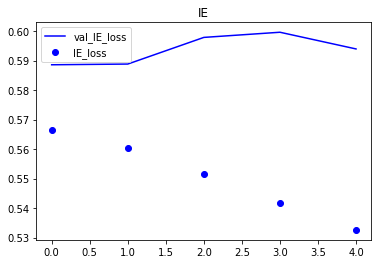

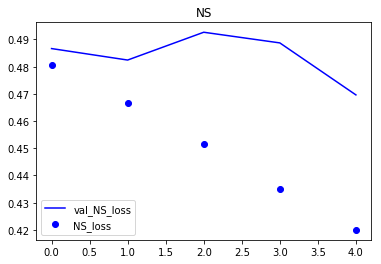

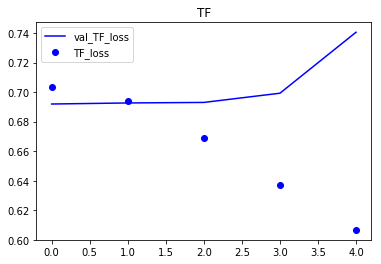

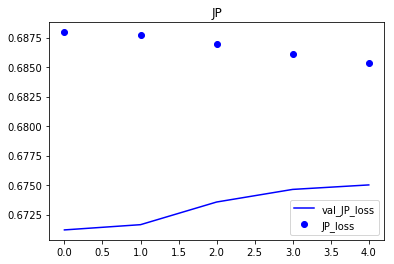

In [12]:
plotting.plot_loss_acc (history)

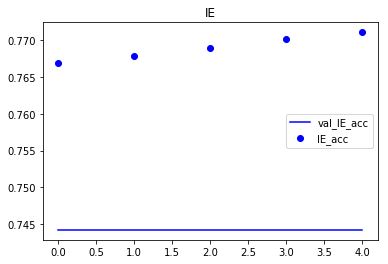

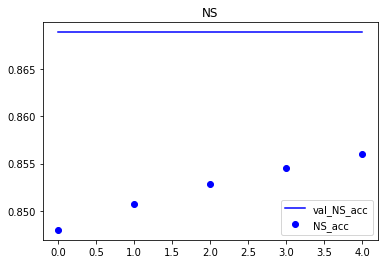

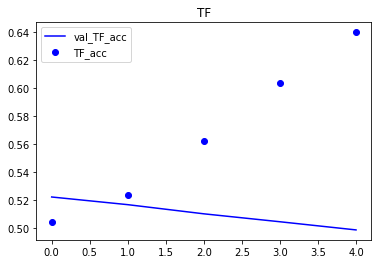

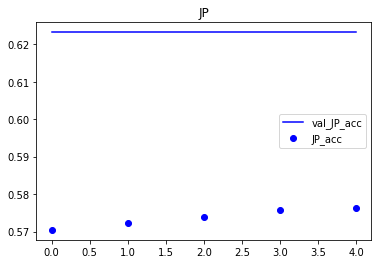

In [13]:
plotting.plot_loss_acc(history, plot_type='acc')

In [14]:
model.evaluate(testX,
               {'IE': test_encoded_list[0],
                'NS': test_encoded_list[1],
                'TF': test_encoded_list[2],
                'JP': test_encoded_list[3],
                })

1735/1735 [==============================] - 5s 3ms/step


[2.602628459985387,
 0.5390147917208823,
 0.4021755351456854,
 0.913538997283243,
 0.6793330629895675,
 0.7694524496707861,
 0.8622478386510689,
 0.4593659943050198,
 0.6046109510258226]

In [21]:
# !tensorboard --logdir=Logs
# http://localhost:6006/

In [22]:
from keras.utils import plot_model
plot_model(model, to_file='1D_CNN/1D_CNN_model.png')

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

In [17]:
"""
Problems to consider:
- allowing the first layer to be trained will overfit
- but freezing that layer will produce little change in validation accuracy
"""
print ('')